## 1. Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series libraries
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prophet
from prophet import Prophet

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

✓ All libraries imported successfully
TensorFlow version: 2.16.2


## 2. Load and Prepare Data

In [2]:
# Load the cleaned data (or original CSV)
try:
    df = pd.read_csv('BTC_cleaned_processed.csv', index_col=0, parse_dates=True)
    print("✓ Loaded cleaned data")
except:
    df = pd.read_csv('BTC_1Jan2025_to_30Nov2025 (1).csv', header=[0, 1], index_col=0)
    df.columns = df.columns.get_level_values(0)
    df.index = pd.to_datetime(df.index)
    df = df[df.index != 'Ticker']
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    print("✓ Loaded and cleaned original data")

# Focus on Close price for forecasting
df_ts = df[['Close']].copy()
df_ts = df_ts.dropna()

print(f"\nDataset shape: {df_ts.shape}")
print(f"Date range: {df_ts.index.min()} to {df_ts.index.max()}")
print(f"\nFirst few rows:")
df_ts.head()

✓ Loaded cleaned data

Dataset shape: (334, 1)
Date range: 2025-01-01 00:00:00 to 2025-11-30 00:00:00

First few rows:


,Close
Date,
2025-01-01,94419.757812
2025-01-02,96886.875000
2025-01-03,98107.429688
2025-01-04,98236.226562
2025-01-05,98314.960938


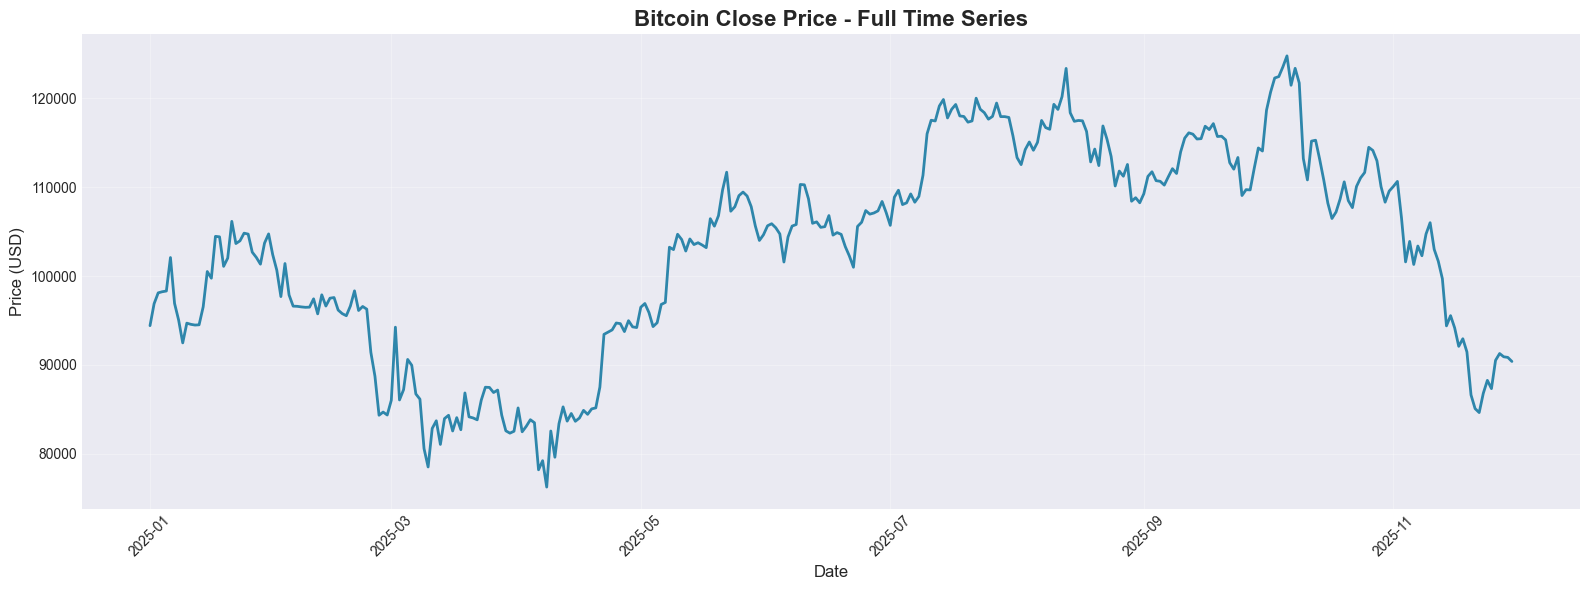

Statistics:
Mean: $102,822.09
Std Dev: $11,582.74
Min: $76,271.95
Max: $124,752.53


In [3]:
# Visualize the time series
plt.figure(figsize=(16, 6))
plt.plot(df_ts.index, df_ts['Close'], linewidth=2, color='#2E86AB')
plt.title('Bitcoin Close Price - Full Time Series', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Statistics:")
print(f"Mean: ${df_ts['Close'].mean():,.2f}")
print(f"Std Dev: ${df_ts['Close'].std():,.2f}")
print(f"Min: ${df_ts['Close'].min():,.2f}")
print(f"Max: ${df_ts['Close'].max():,.2f}")

## 3. Train-Test Split

Training set: 267 days (2025-01-01 00:00:00 to 2025-09-24 00:00:00)
Test set: 67 days (2025-09-25 00:00:00 to 2025-11-30 00:00:00)


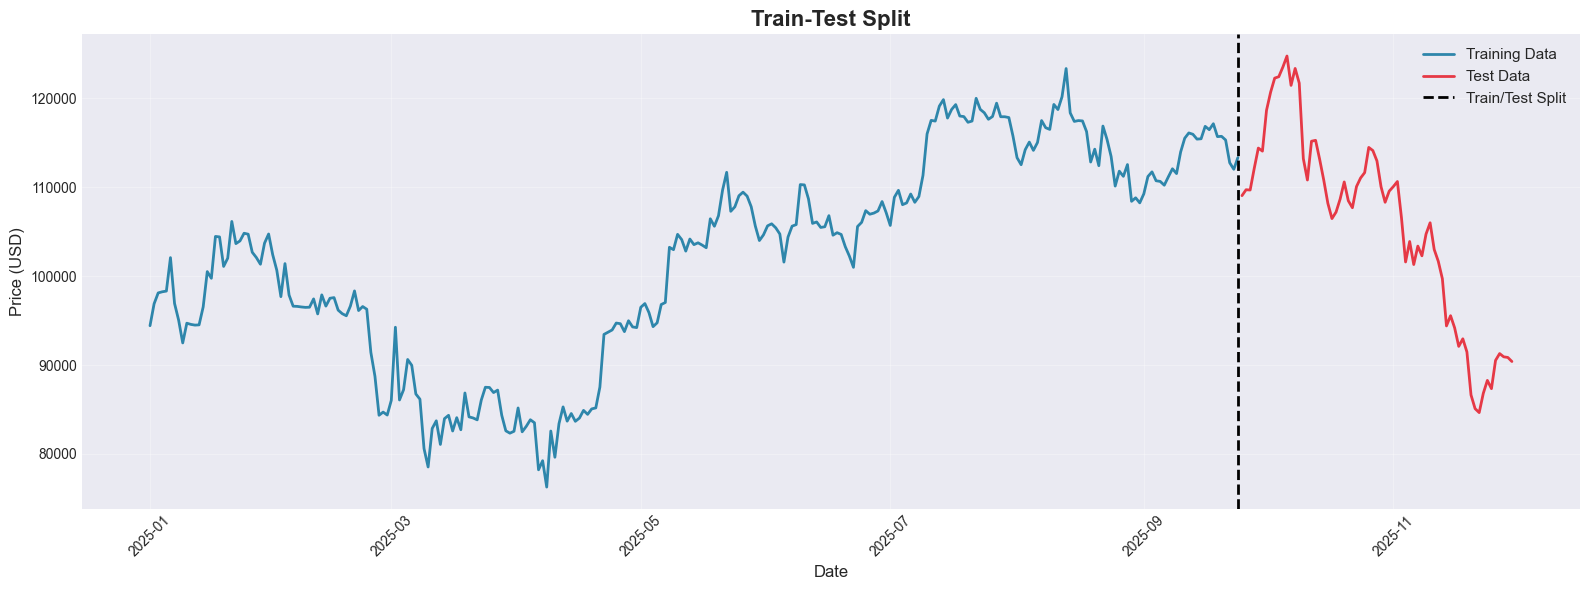

In [4]:
# Split data: 80% train, 20% test
train_size = int(len(df_ts) * 0.8)
train_data = df_ts.iloc[:train_size].copy()
test_data = df_ts.iloc[train_size:].copy()

print(f"Training set: {len(train_data)} days ({train_data.index.min()} to {train_data.index.max()})")
print(f"Test set: {len(test_data)} days ({test_data.index.min()} to {test_data.index.max()})")

# Visualize split
plt.figure(figsize=(16, 6))
plt.plot(train_data.index, train_data['Close'], label='Training Data', linewidth=2, color='#2E86AB')
plt.plot(test_data.index, test_data['Close'], label='Test Data', linewidth=2, color='#E63946')
plt.axvline(x=train_data.index[-1], color='black', linestyle='--', linewidth=2, label='Train/Test Split')
plt.title('Train-Test Split', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Time Series Analysis

### 4.1 Stationarity Test (ADF Test)

In [5]:
def adf_test(series, name=''):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna())
    print(f"ADF Test Results for {name}:")
    print("="*60)
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    if result[1] <= 0.05:
        print("\n✓ Series is STATIONARY (reject null hypothesis)")
    else:
        print("\n✗ Series is NON-STATIONARY (fail to reject null hypothesis)")
    print("="*60)
    return result[1] <= 0.05

# Test original series
is_stationary = adf_test(train_data['Close'], 'Original Series')

ADF Test Results for Original Series:
ADF Statistic: -1.159377
p-value: 0.690822
Critical Values:
  1%: -3.455
  5%: -2.873
  10%: -2.573

✗ Series is NON-STATIONARY (fail to reject null hypothesis)


### 4.2 Make Series Stationary (Differencing)


After First Differencing:
ADF Test Results for Differenced Series:
ADF Statistic: -18.465720
p-value: 0.000000
Critical Values:
  1%: -3.455
  5%: -2.873
  10%: -2.573

✓ Series is STATIONARY (reject null hypothesis)


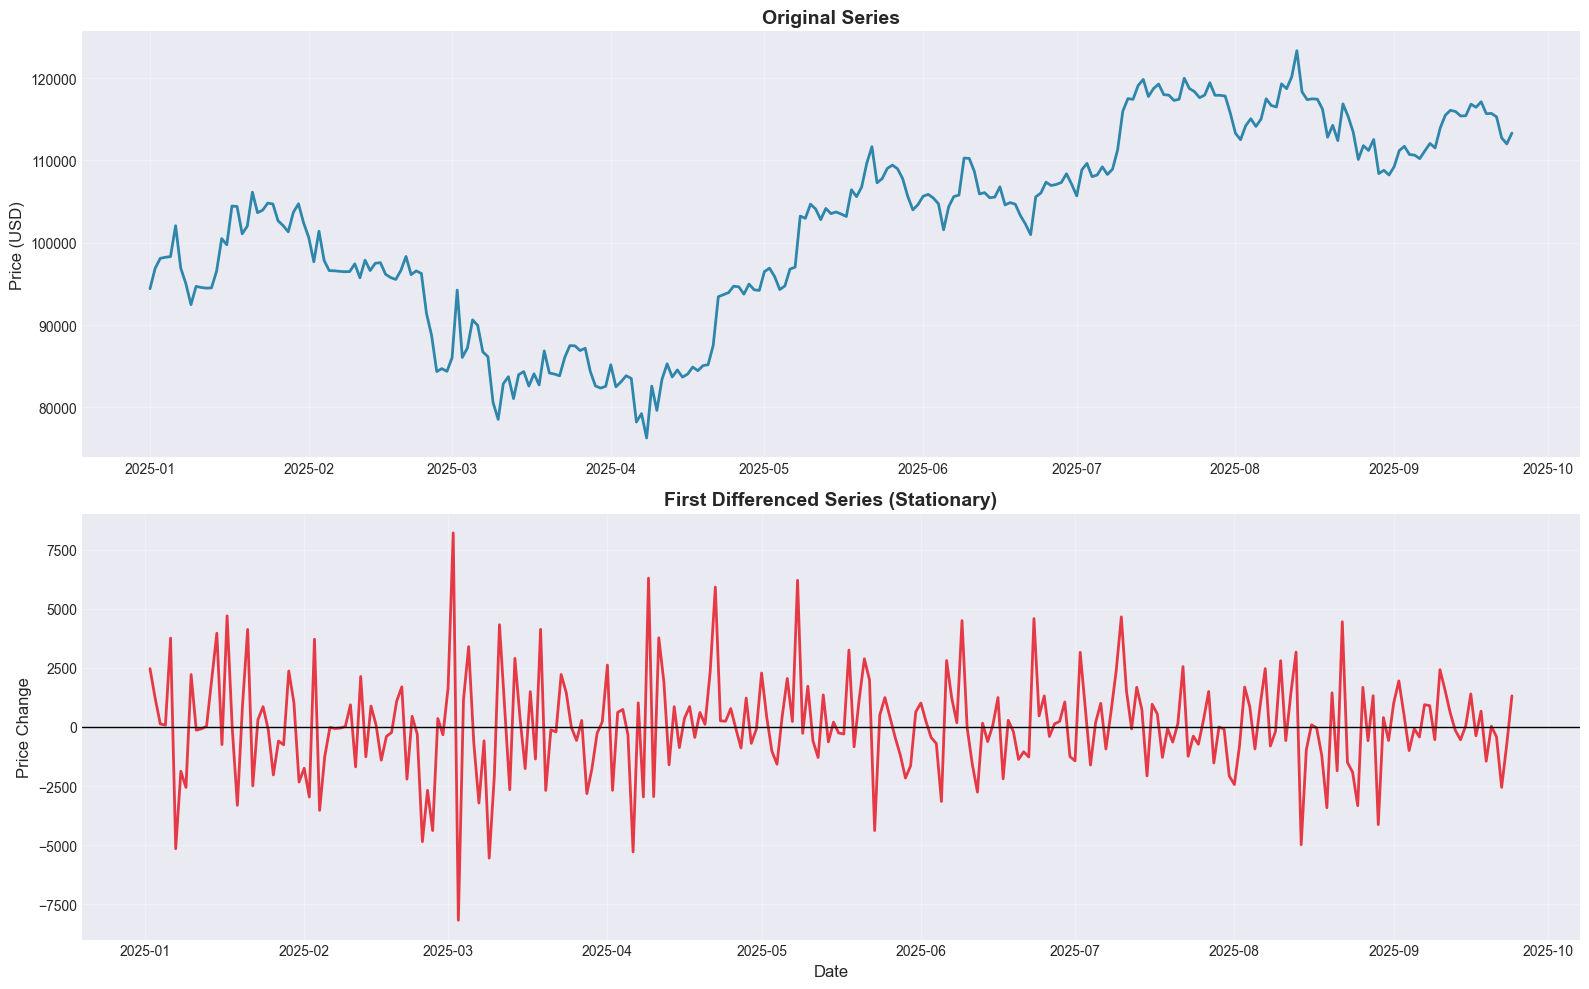

In [6]:
# First differencing
train_diff = train_data['Close'].diff().dropna()

print("\nAfter First Differencing:")
is_stationary_diff = adf_test(train_diff, 'Differenced Series')

# Visualize differencing
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[0].plot(train_data.index, train_data['Close'], linewidth=2, color='#2E86AB')
axes[0].set_title('Original Series', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_diff.index, train_diff, linewidth=2, color='#E63946')
axes[1].set_title('First Differenced Series (Stationary)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Price Change', fontsize=12)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3 ACF and PACF Plots

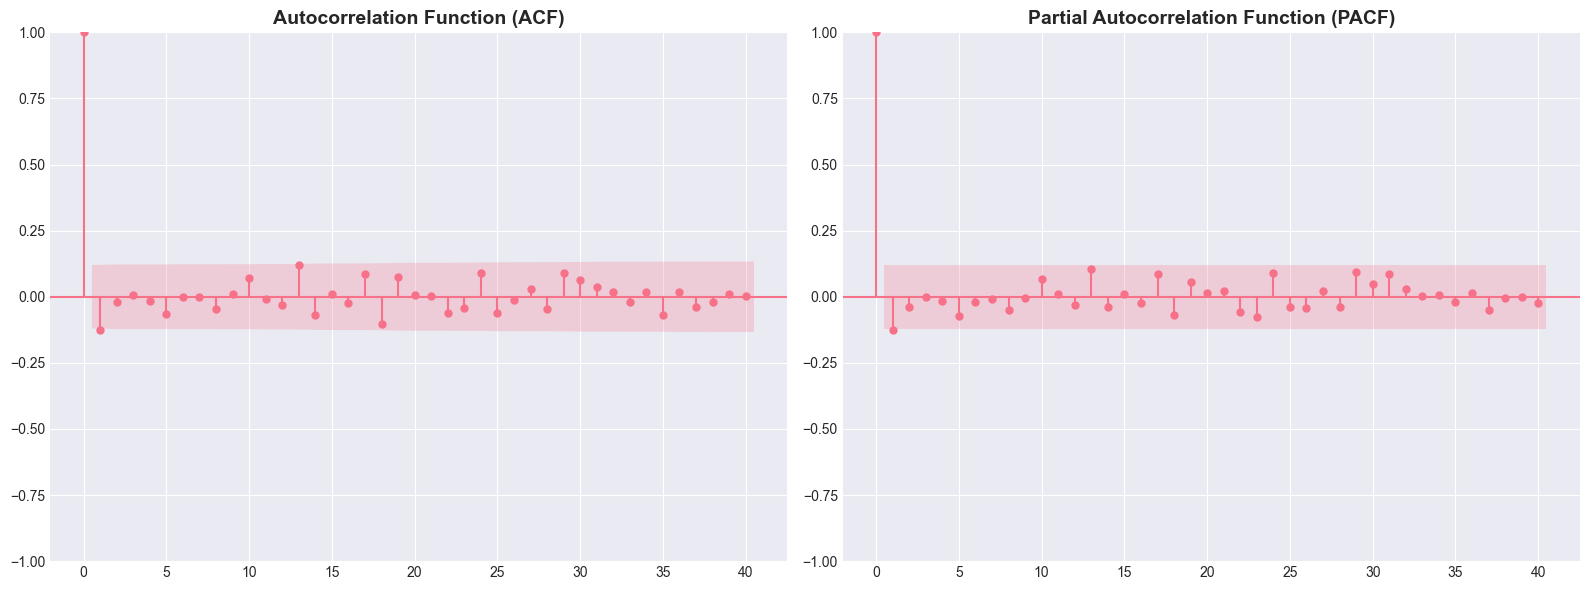


ACF and PACF plots help determine ARIMA parameters (p, d, q)
- p (AR order): Significant lags in PACF
- d (differencing): Number of times differenced (1 in our case)
- q (MA order): Significant lags in ACF


In [7]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(train_diff, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')

plot_pacf(train_diff, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nACF and PACF plots help determine ARIMA parameters (p, d, q)")
print("- p (AR order): Significant lags in PACF")
print("- d (differencing): Number of times differenced (1 in our case)")
print("- q (MA order): Significant lags in ACF")

## 5. Model 1: ARIMA (Auto-Regressive Integrated Moving Average)

### 5.1 Train ARIMA Model

In [8]:
# Define ARIMA parameters
# (p, d, q) - Based on ACF/PACF analysis
order = (5, 1, 2)  # Commonly used values, can be tuned

print(f"Training ARIMA{order} model...")
print("="*60)

# Fit ARIMA model
arima_model = ARIMA(train_data['Close'], order=order)
arima_fit = arima_model.fit()

print("✓ ARIMA model trained successfully!")
print("\nModel Summary:")
print(arima_fit.summary())

Training ARIMA(5, 1, 2) model...


c:\Users\91701\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\91701\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\91701\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


✓ ARIMA model trained successfully!

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  267
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2409.980
Date:                Fri, 05 Dec 2025   AIC                           4835.961
Time:                        19:39:08   BIC                           4864.629
Sample:                    01-01-2025   HQIC                          4847.478
                         - 09-24-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8567      0.873     -0.982      0.326      -2.567       0.853
ar.L2         -0.1189      0.764     -0.156      0.876      -1.616       1.378


### 5.2 ARIMA Predictions

In [9]:
# Make predictions on test set
arima_predictions = arima_fit.forecast(steps=len(test_data))
arima_predictions_series = pd.Series(arima_predictions, index=test_data.index)

# Calculate metrics
arima_mae = mean_absolute_error(test_data['Close'], arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(test_data['Close'], arima_predictions))
arima_mape = np.mean(np.abs((test_data['Close'] - arima_predictions) / test_data['Close'])) * 100
arima_r2 = r2_score(test_data['Close'], arima_predictions)

print("ARIMA Model Performance:")
print("="*60)
print(f"Mean Absolute Error (MAE): ${arima_mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${arima_rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {arima_mape:.2f}%")
print(f"R² Score: {arima_r2:.4f}")
print("="*60)

ARIMA Model Performance:
Mean Absolute Error (MAE): $10,037.27
Root Mean Squared Error (RMSE): $13,126.20
Mean Absolute Percentage Error (MAPE): 10.34%
R² Score: -0.4784


### 5.3 Visualize ARIMA Results

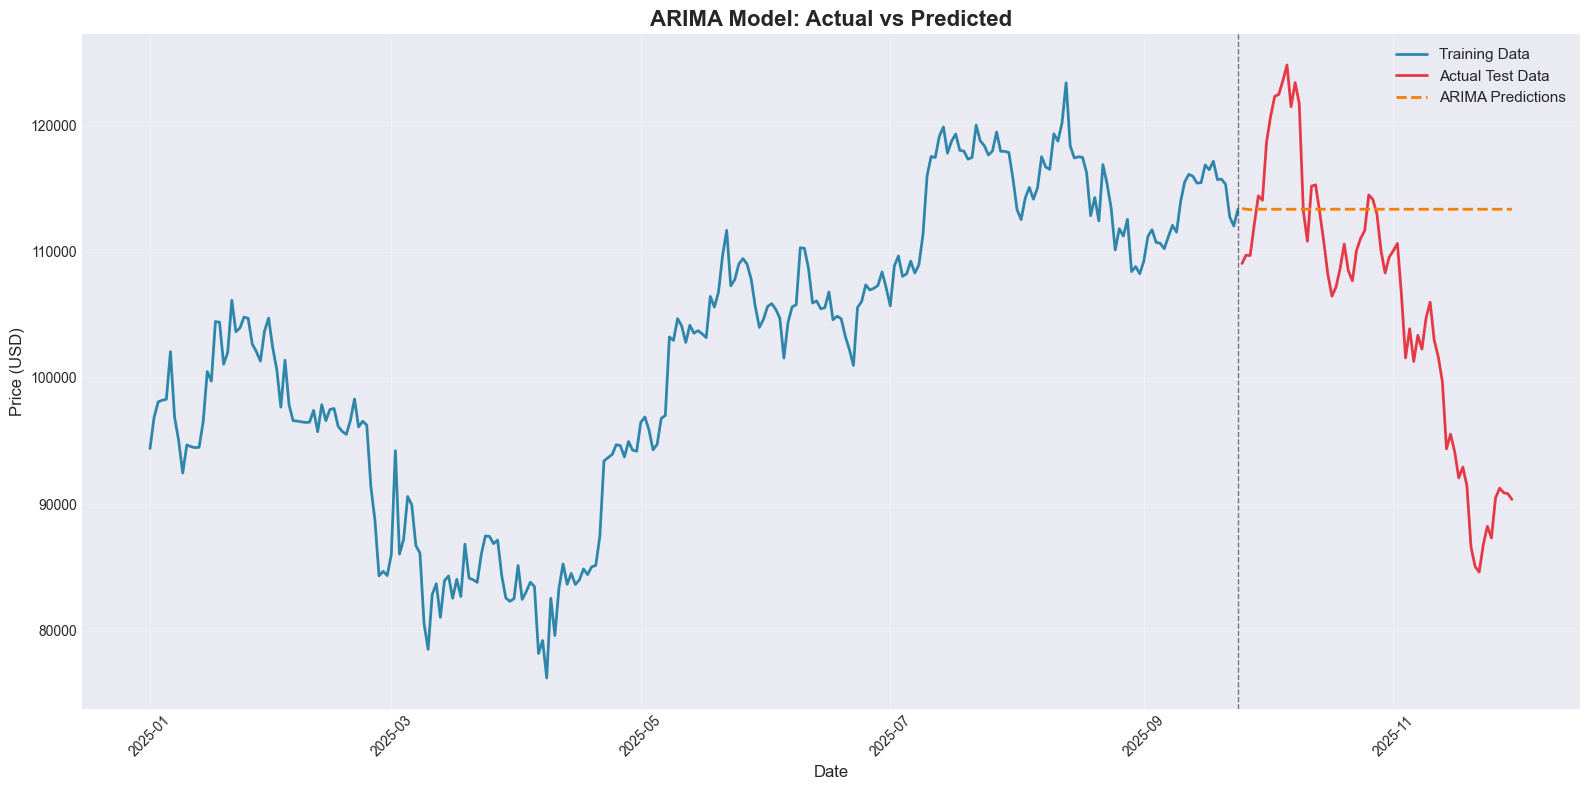

In [10]:
# Plot ARIMA predictions
plt.figure(figsize=(16, 8))

plt.plot(train_data.index, train_data['Close'], label='Training Data', linewidth=2, color='#2E86AB')
plt.plot(test_data.index, test_data['Close'], label='Actual Test Data', linewidth=2, color='#E63946')
plt.plot(arima_predictions_series.index, arima_predictions_series, 
         label='ARIMA Predictions', linewidth=2, color='#F77F00', linestyle='--')

plt.axvline(x=train_data.index[-1], color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.title('ARIMA Model: Actual vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.4 ARIMA Future Forecast

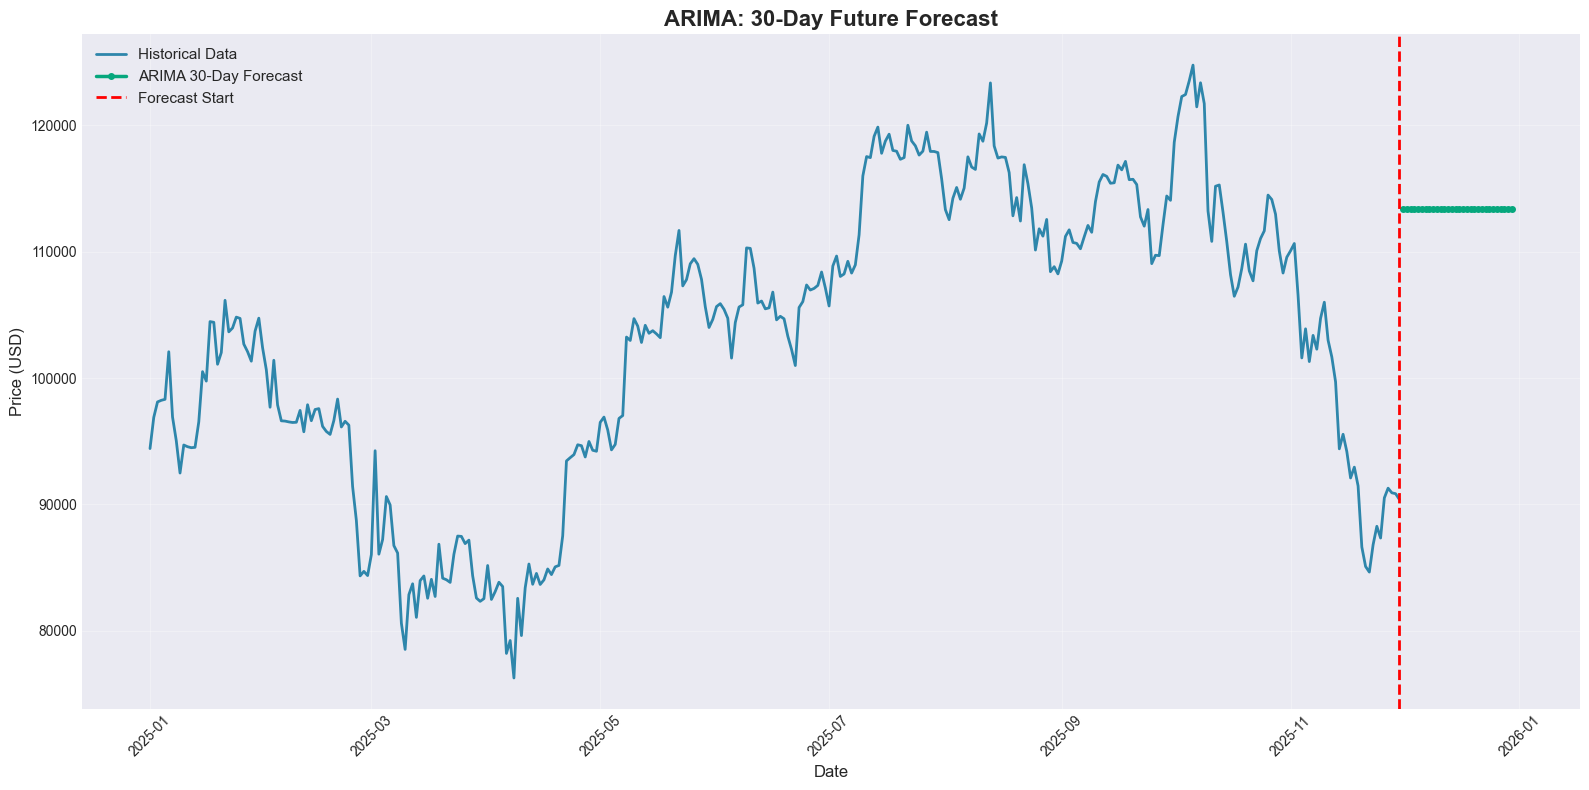


ARIMA 30-Day Forecast:
Starting Price: $90,394.31
Predicted Price (Day 30): $113,344.43
Predicted Change: $22,950.12 (+25.39%)


In [11]:
# Forecast next 30 days into the future
future_days = 30
arima_future = arima_fit.forecast(steps=len(test_data) + future_days)

# Create future dates
last_date = df_ts.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_days, freq='D')
arima_future_30 = arima_future[-future_days:]

# Plot future forecast
plt.figure(figsize=(16, 8))

plt.plot(df_ts.index, df_ts['Close'], label='Historical Data', linewidth=2, color='#2E86AB')
plt.plot(future_dates, arima_future_30, label='ARIMA 30-Day Forecast', 
         linewidth=2.5, color='#06A77D', marker='o', markersize=4)

plt.axvline(x=df_ts.index[-1], color='red', linestyle='--', linewidth=2, label='Forecast Start')
plt.title('ARIMA: 30-Day Future Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nARIMA 30-Day Forecast:")
print(f"Starting Price: ${df_ts['Close'].iloc[-1]:,.2f}")
print(f"Predicted Price (Day 30): ${arima_future_30.iloc[-1]:,.2f}")
print(f"Predicted Change: ${arima_future_30.iloc[-1] - df_ts['Close'].iloc[-1]:,.2f} ({((arima_future_30.iloc[-1] / df_ts['Close'].iloc[-1]) - 1) * 100:+.2f}%)")

## 6. Model 2: LSTM (Long Short-Term Memory)

### 6.1 Prepare Data for LSTM

In [12]:
# Scale data to 0-1 range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_ts[['Close']].values)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Use 60 days to predict next day
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"LSTM Data Preparation:")
print("="*60)
print(f"Training sequences: {X_train.shape[0]}")
print(f"Test sequences: {X_test.shape[0]}")
print(f"Sequence length: {sequence_length} days")
print(f"Input shape: {X_train.shape}")
print("="*60)

LSTM Data Preparation:
Training sequences: 219
Test sequences: 55
Sequence length: 60 days
Input shape: (219, 60, 1)


### 6.2 Build LSTM Model

In [13]:
# Build LSTM architecture
print("Building LSTM Model...")
print("="*60)

lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    
    Dense(units=25),
    Dense(units=1)
])

# Compile model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

print("✓ LSTM Model built successfully!")
print("\nModel Architecture:")
lstm_model.summary()

Building LSTM Model...
✓ LSTM Model built successfully!

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

### 6.3 Train LSTM Model

In [14]:
# Train model with early stopping
print("Training LSTM Model...")
print("="*60)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

print("\n✓ LSTM model trained successfully!")

Training LSTM Model...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.2199 - val_loss: 0.1568
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.2199 - val_loss: 0.1568
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0430 - val_loss: 0.0243
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0430 - val_loss: 0.0243
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0303 - val_loss: 0.0551
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0303 - val_loss: 0.0551
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0264 - val_loss: 0.0329
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0264 - val_loss: 0.0329
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0228 - val_loss: 0.0242
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0228 - val_loss: 0.0242
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0145 - val_loss: 0.0409
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0145 

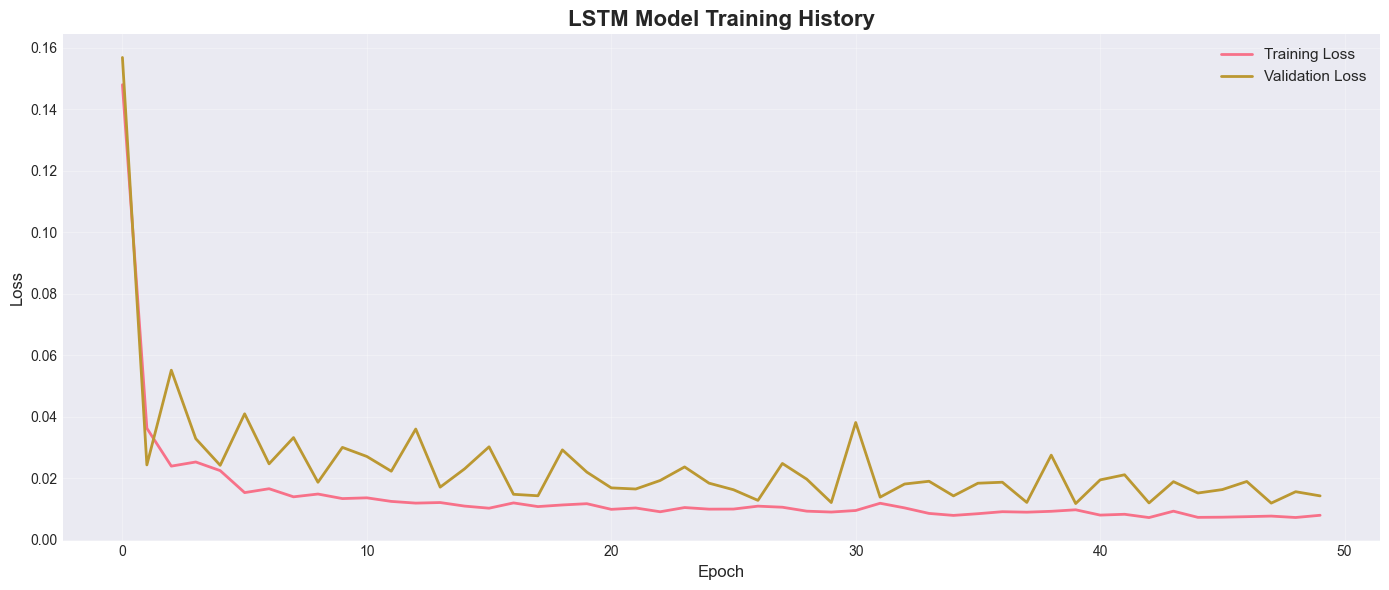

In [15]:
# Plot training history
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Model Training History', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.4 LSTM Predictions

In [16]:
# Make predictions
lstm_train_predictions = lstm_model.predict(X_train)
lstm_test_predictions = lstm_model.predict(X_test)

# Inverse transform to get actual prices
lstm_train_predictions = scaler.inverse_transform(lstm_train_predictions)
lstm_test_predictions = scaler.inverse_transform(lstm_test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
lstm_mae = mean_absolute_error(y_test_actual, lstm_test_predictions)
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_test_predictions))
lstm_mape = np.mean(np.abs((y_test_actual - lstm_test_predictions) / y_test_actual)) * 100
lstm_r2 = r2_score(y_test_actual, lstm_test_predictions)

print("LSTM Model Performance:")
print("="*60)
print(f"Mean Absolute Error (MAE): ${lstm_mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${lstm_rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {lstm_mape:.2f}%")
print(f"R² Score: {lstm_r2:.4f}")
print("="*60)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
LSTM Model Performance:
Mean Absolute Error (MAE): $4,485.46
Root Mean Squared Error (RMSE): $5,256.77
Mean Absolute Percentage Error (MAPE): 4.46%
R² Score: 0.7328
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
LSTM Model Performance:
Mean Absolute Error (MAE): $4,485.46
Root Mean Squared Error (RMSE): $5,256.77
Mean Absolute Percentage Error (MAPE): 4.46%
R² Score: 0.7328


### 6.5 Visualize LSTM Results

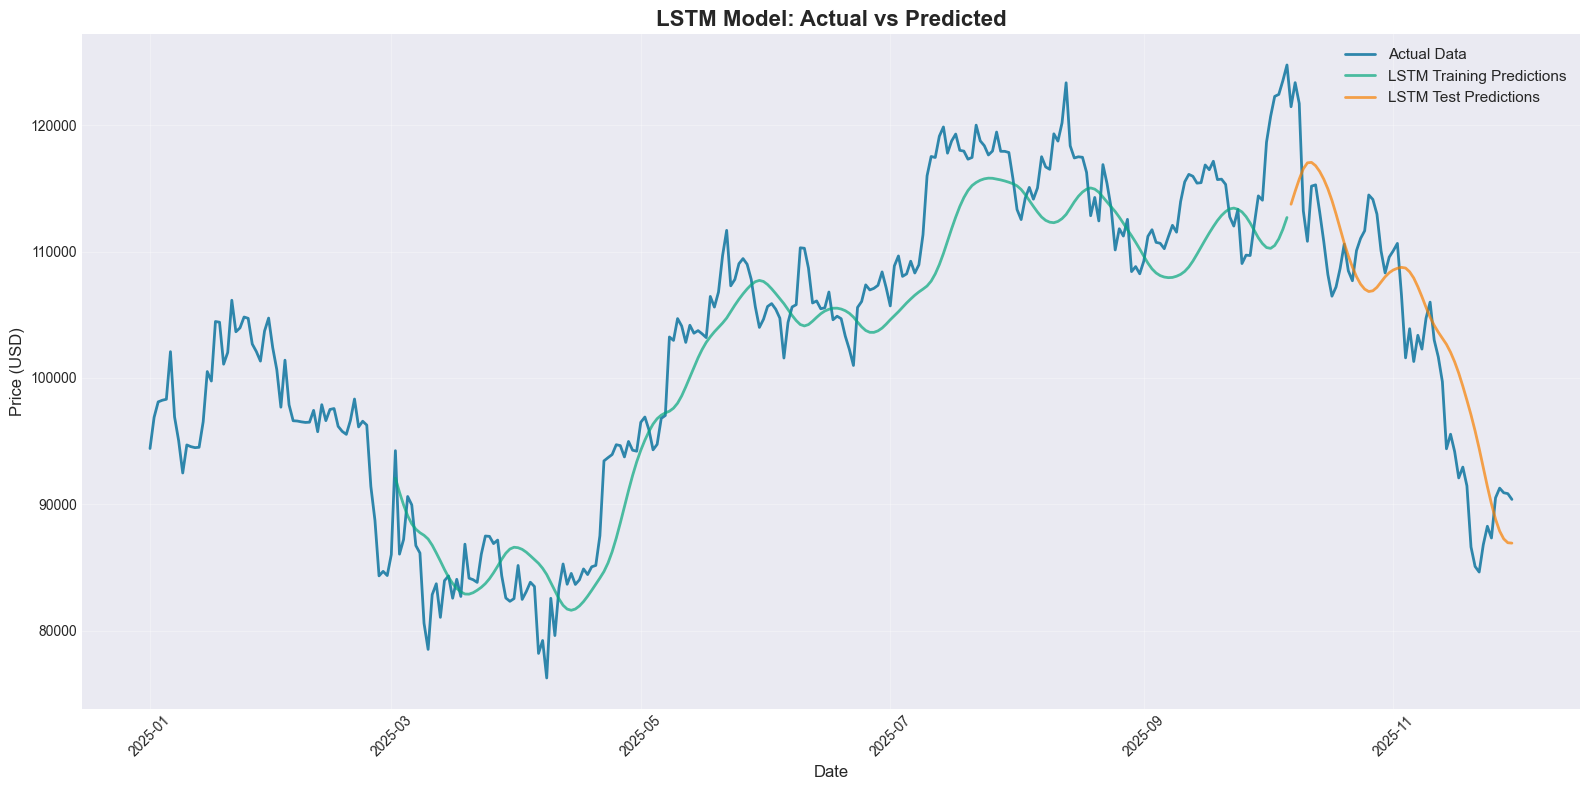

In [18]:
# Create visualization
plt.figure(figsize=(16, 8))

# Actual data
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[sequence_length:len(lstm_train_predictions)+sequence_length, :] = lstm_train_predictions

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(lstm_train_predictions)+sequence_length:len(lstm_train_predictions)+sequence_length+len(lstm_test_predictions), :] = lstm_test_predictions

# Plot
plt.plot(df_ts.index, df_ts['Close'], label='Actual Data', linewidth=2, color='#2E86AB')
plt.plot(df_ts.index, train_plot, label='LSTM Training Predictions', linewidth=2, color='#06A77D', alpha=0.7)
plt.plot(df_ts.index, test_plot, label='LSTM Test Predictions', linewidth=2, color='#F77F00', alpha=0.7)

plt.title('LSTM Model: Actual vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 6.6 LSTM Future Forecast

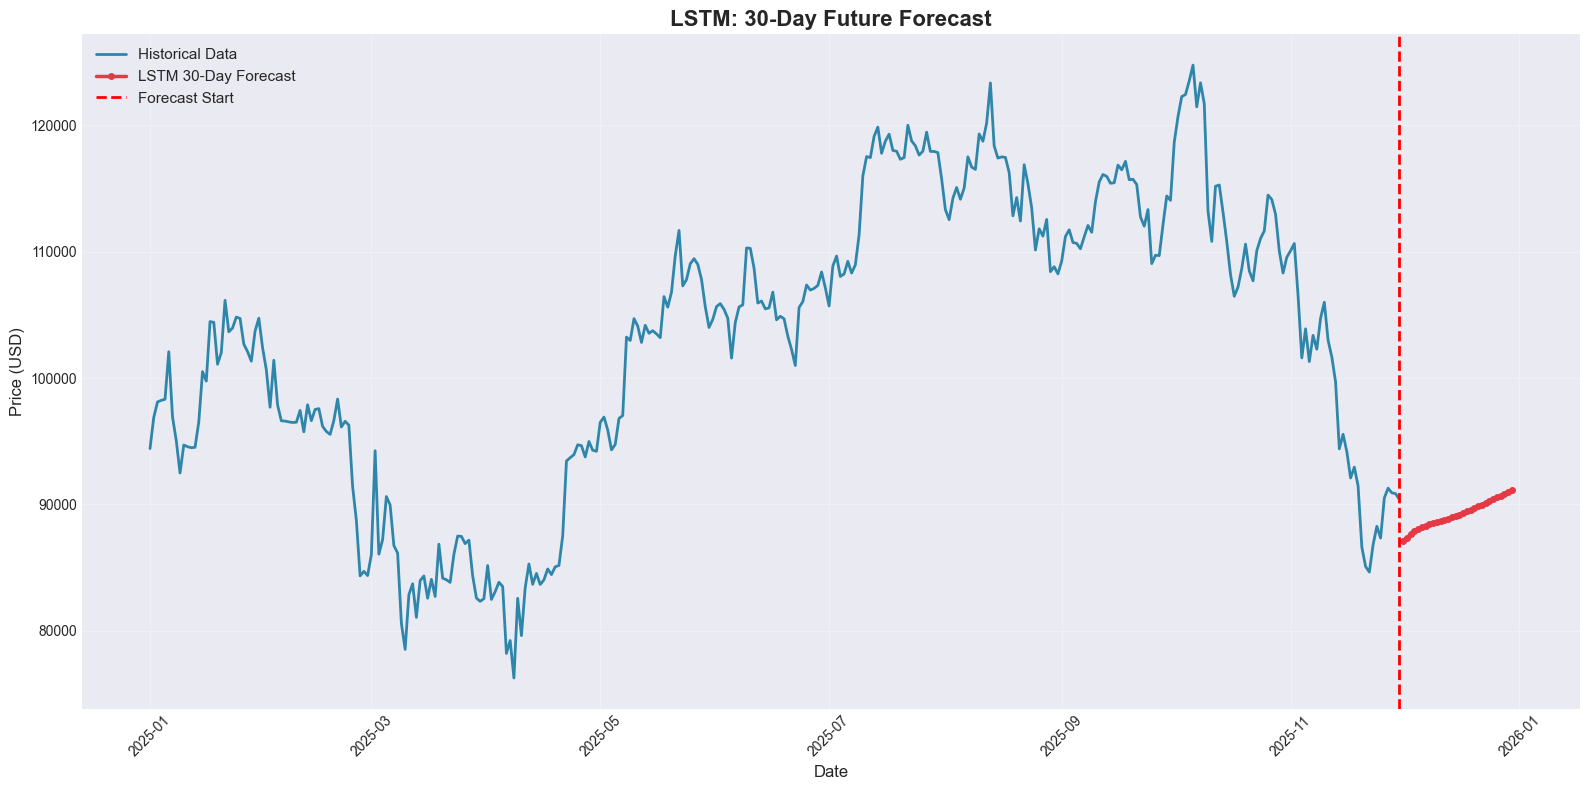


LSTM 30-Day Forecast:
Starting Price: $90,394.31
Predicted Price (Day 30): $91,122.09
Predicted Change: $727.78 (+0.81%)


In [19]:
# Forecast next 30 days
future_days = 30
last_sequence = scaled_data[-sequence_length:]
lstm_future_predictions = []

current_sequence = last_sequence.copy()

for _ in range(future_days):
    # Reshape for prediction
    current_input = current_sequence.reshape((1, sequence_length, 1))
    
    # Predict next value
    next_pred = lstm_model.predict(current_input, verbose=0)
    lstm_future_predictions.append(next_pred[0, 0])
    
    # Update sequence: remove first value, add prediction
    current_sequence = np.append(current_sequence[1:], next_pred[0])

# Inverse transform predictions
lstm_future_predictions = scaler.inverse_transform(np.array(lstm_future_predictions).reshape(-1, 1))

# Create future dates
last_date = df_ts.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_days, freq='D')

# Plot
plt.figure(figsize=(16, 8))

plt.plot(df_ts.index, df_ts['Close'], label='Historical Data', linewidth=2, color='#2E86AB')
plt.plot(future_dates, lstm_future_predictions, label='LSTM 30-Day Forecast', 
         linewidth=2.5, color='#E63946', marker='o', markersize=4)

plt.axvline(x=df_ts.index[-1], color='red', linestyle='--', linewidth=2, label='Forecast Start')
plt.title('LSTM: 30-Day Future Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nLSTM 30-Day Forecast:")
print(f"Starting Price: ${df_ts['Close'].iloc[-1]:,.2f}")
print(f"Predicted Price (Day 30): ${lstm_future_predictions[-1][0]:,.2f}")
print(f"Predicted Change: ${lstm_future_predictions[-1][0] - df_ts['Close'].iloc[-1]:,.2f} ({((lstm_future_predictions[-1][0] / df_ts['Close'].iloc[-1]) - 1) * 100:+.2f}%)")

## 7. Model 3: Facebook Prophet

### 7.1 Prepare Data for Prophet

In [20]:
# Prophet requires 'ds' (date) and 'y' (value) columns
prophet_data = df_ts.reset_index()
prophet_data.columns = ['ds', 'y']

# Split train/test
prophet_train = prophet_data.iloc[:train_size].copy()
prophet_test = prophet_data.iloc[train_size:].copy()

print(f"Prophet Data Preparation:")
print("="*60)
print(f"Training samples: {len(prophet_train)}")
print(f"Test samples: {len(prophet_test)}")
print("\nFirst few rows:")
prophet_train.head()

Prophet Data Preparation:
Training samples: 219
Test samples: 115

First few rows:


,ds,y
0,2025-01-01,94419.757812
1,2025-01-02,96886.875000
2,2025-01-03,98107.429688
3,2025-01-04,98236.226562
4,2025-01-05,98314.960938


### 7.2 Train Prophet Model

In [21]:
# Initialize and train Prophet model
print("Training Prophet Model...")
print("="*60)

prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10
)

prophet_model.fit(prophet_train)

print("✓ Prophet model trained successfully!")

19:41:49 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet Model...


19:41:49 - cmdstanpy - INFO - Chain [1] done processing


✓ Prophet model trained successfully!


### 7.3 Prophet Predictions

In [22]:
# Make predictions on test set
prophet_forecast = prophet_model.predict(prophet_test[['ds']])

# Calculate metrics
prophet_mae = mean_absolute_error(prophet_test['y'], prophet_forecast['yhat'])
prophet_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_forecast['yhat']))
prophet_mape = np.mean(np.abs((prophet_test['y'] - prophet_forecast['yhat']) / prophet_test['y'])) * 100
prophet_r2 = r2_score(prophet_test['y'], prophet_forecast['yhat'])

print("Prophet Model Performance:")
print("="*60)
print(f"Mean Absolute Error (MAE): ${prophet_mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${prophet_rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {prophet_mape:.2f}%")
print(f"R² Score: {prophet_r2:.4f}")
print("="*60)

Prophet Model Performance:
Mean Absolute Error (MAE): $21,555.21
Root Mean Squared Error (RMSE): $26,434.59
Mean Absolute Percentage Error (MAPE): nan%
R² Score: -6.8063


### 7.4 Visualize Prophet Results

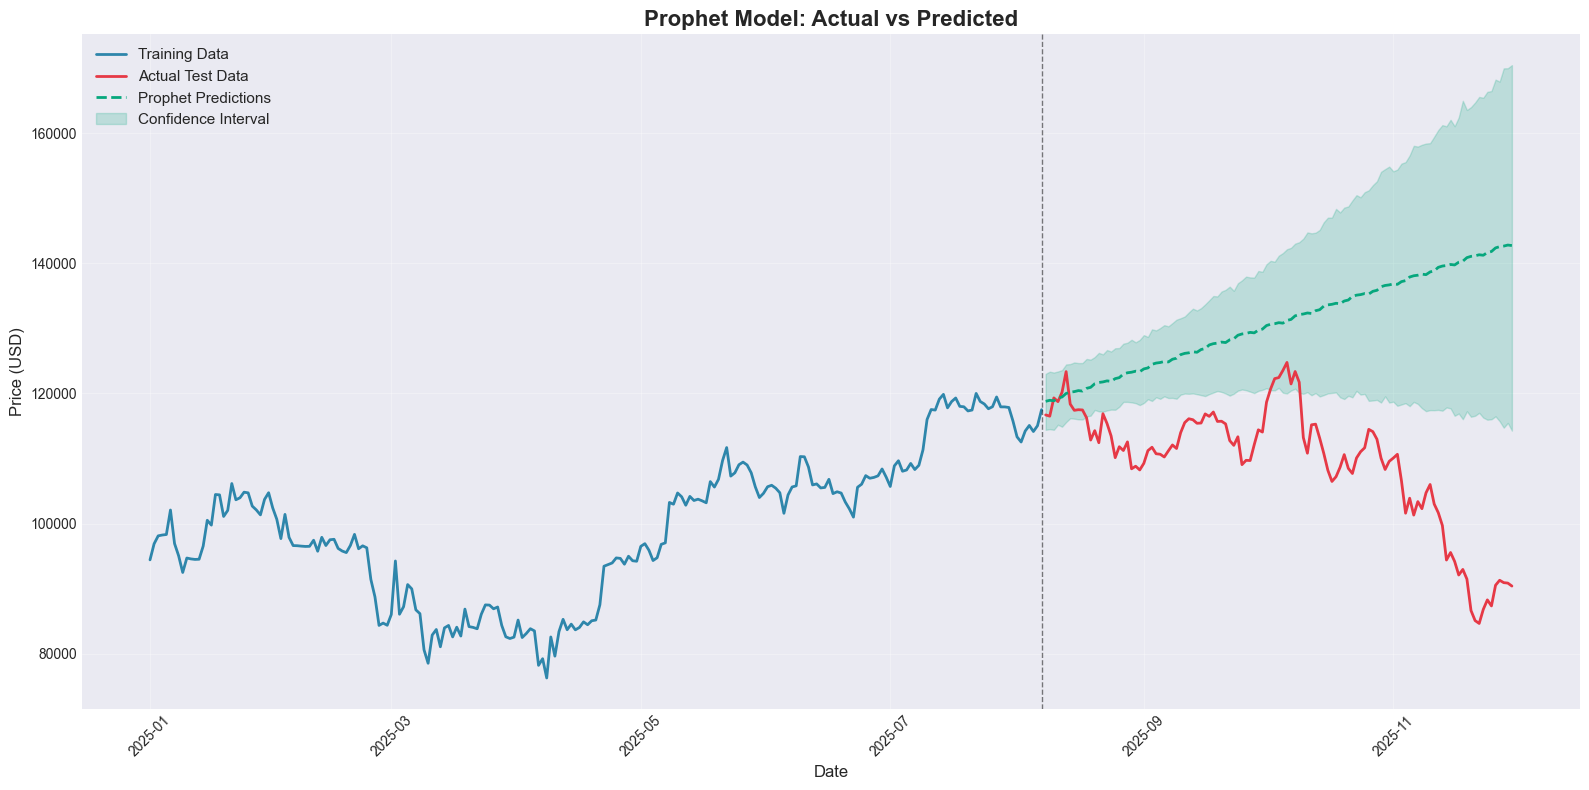

In [23]:
# Plot Prophet predictions
plt.figure(figsize=(16, 8))

plt.plot(prophet_train['ds'], prophet_train['y'], label='Training Data', linewidth=2, color='#2E86AB')
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual Test Data', linewidth=2, color='#E63946')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], 
         label='Prophet Predictions', linewidth=2, color='#06A77D', linestyle='--')

# Add confidence interval
plt.fill_between(prophet_forecast['ds'], 
                 prophet_forecast['yhat_lower'], 
                 prophet_forecast['yhat_upper'], 
                 alpha=0.2, color='#06A77D', label='Confidence Interval')

plt.axvline(x=prophet_train['ds'].iloc[-1], color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.title('Prophet Model: Actual vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 7.5 Prophet Components Analysis

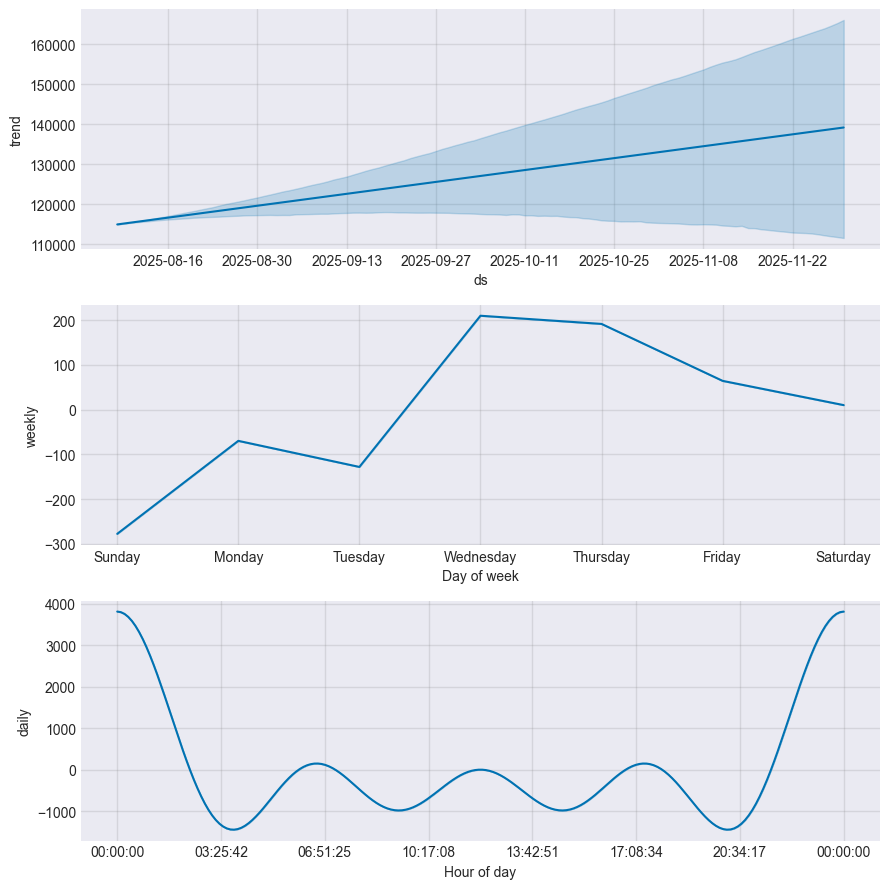


Component Analysis:
- Trend: Overall direction of the price
- Weekly: Day-of-week patterns
- Daily: Intra-day patterns (if applicable)


In [24]:
# Plot components (trend, weekly, daily seasonality)
fig = prophet_model.plot_components(prophet_forecast)
plt.tight_layout()
plt.show()

print("\nComponent Analysis:")
print("- Trend: Overall direction of the price")
print("- Weekly: Day-of-week patterns")
print("- Daily: Intra-day patterns (if applicable)")

### 7.6 Prophet Future Forecast

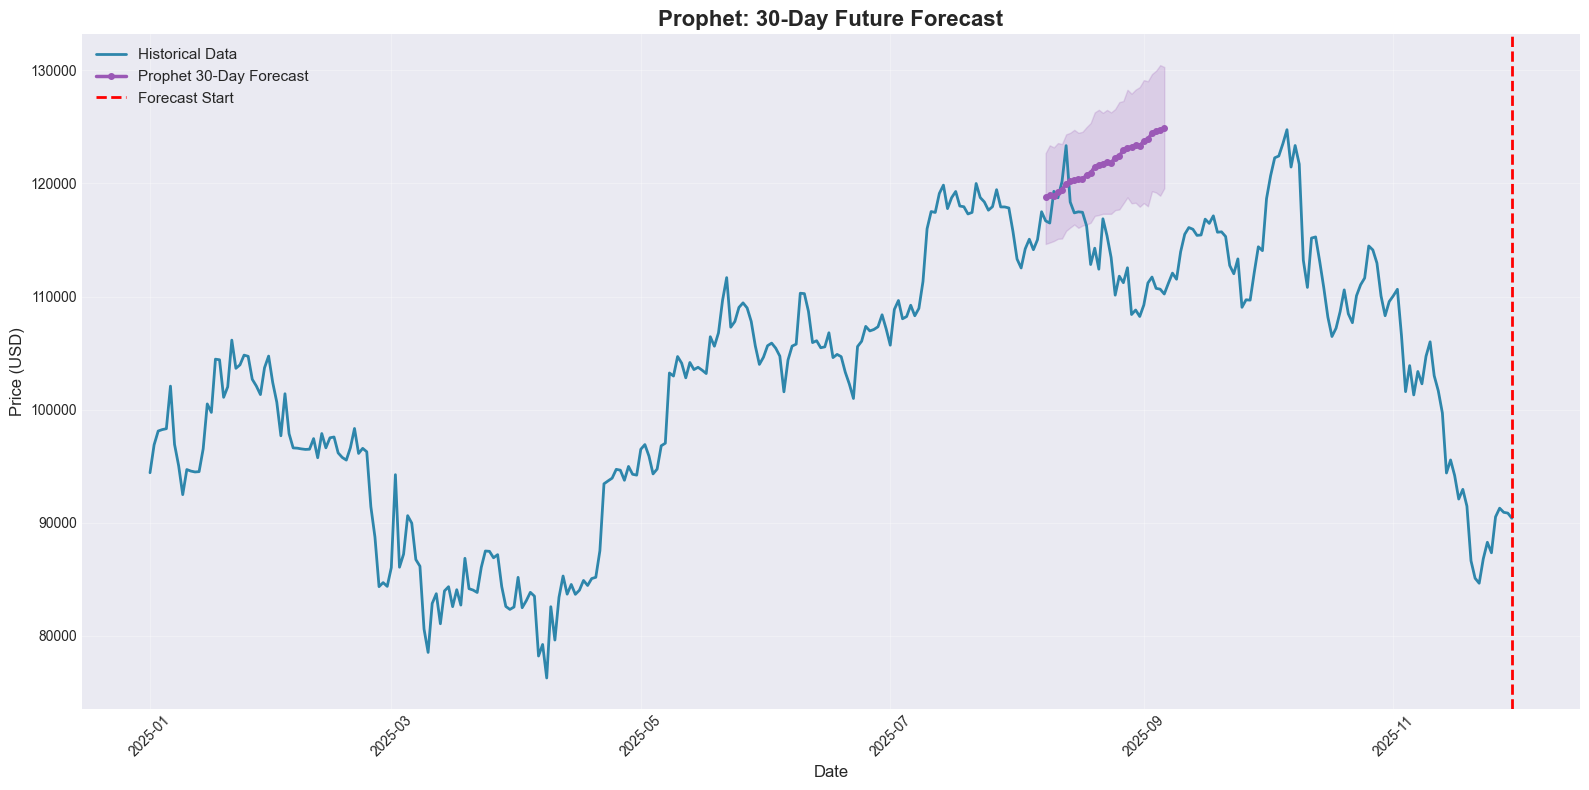


Prophet 30-Day Forecast:
Starting Price: $90,394.31
Predicted Price (Day 30): $124,900.14
Predicted Change: $34,505.83 (+38.17%)

Confidence Interval (Day 30):
Lower Bound: $119,571.63
Upper Bound: $130,296.20


In [25]:
# Create future dataframe for 30 days
future_days = 30
future = prophet_model.make_future_dataframe(periods=future_days, freq='D')
prophet_future_forecast = prophet_model.predict(future)

# Get last 30 days of forecast
prophet_future_30 = prophet_future_forecast.tail(future_days)

# Plot
plt.figure(figsize=(16, 8))

plt.plot(prophet_data['ds'], prophet_data['y'], label='Historical Data', linewidth=2, color='#2E86AB')
plt.plot(prophet_future_30['ds'], prophet_future_30['yhat'], 
         label='Prophet 30-Day Forecast', linewidth=2.5, color='#9B59B6', marker='o', markersize=4)

# Add confidence interval
plt.fill_between(prophet_future_30['ds'], 
                 prophet_future_30['yhat_lower'], 
                 prophet_future_30['yhat_upper'], 
                 alpha=0.2, color='#9B59B6')

plt.axvline(x=prophet_data['ds'].iloc[-1], color='red', linestyle='--', linewidth=2, label='Forecast Start')
plt.title('Prophet: 30-Day Future Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nProphet 30-Day Forecast:")
print(f"Starting Price: ${prophet_data['y'].iloc[-1]:,.2f}")
print(f"Predicted Price (Day 30): ${prophet_future_30['yhat'].iloc[-1]:,.2f}")
print(f"Predicted Change: ${prophet_future_30['yhat'].iloc[-1] - prophet_data['y'].iloc[-1]:,.2f} ({((prophet_future_30['yhat'].iloc[-1] / prophet_data['y'].iloc[-1]) - 1) * 100:+.2f}%)")
print(f"\nConfidence Interval (Day 30):")
print(f"Lower Bound: ${prophet_future_30['yhat_lower'].iloc[-1]:,.2f}")
print(f"Upper Bound: ${prophet_future_30['yhat_upper'].iloc[-1]:,.2f}")

## 8. Model Comparison

In [26]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM', 'Prophet'],
    'MAE': [arima_mae, lstm_mae, prophet_mae],
    'RMSE': [arima_rmse, lstm_rmse, prophet_rmse],
    'MAPE (%)': [arima_mape, lstm_mape, prophet_mape],
    'R² Score': [arima_r2, lstm_r2, prophet_r2]
})

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)

# Find best model
best_model_idx = comparison['RMSE'].idxmin()
best_model = comparison.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model (Lowest RMSE): {best_model}")
print("="*80)


MODEL PERFORMANCE COMPARISON
  Model          MAE         RMSE  MAPE (%)  R² Score
  ARIMA 10037.270093 13126.199258 10.342826 -0.478354
   LSTM  4485.460653  5256.765704  4.456836  0.732799
Prophet 21555.208505 26434.594185       NaN -6.806267

🏆 Best Model (Lowest RMSE): LSTM


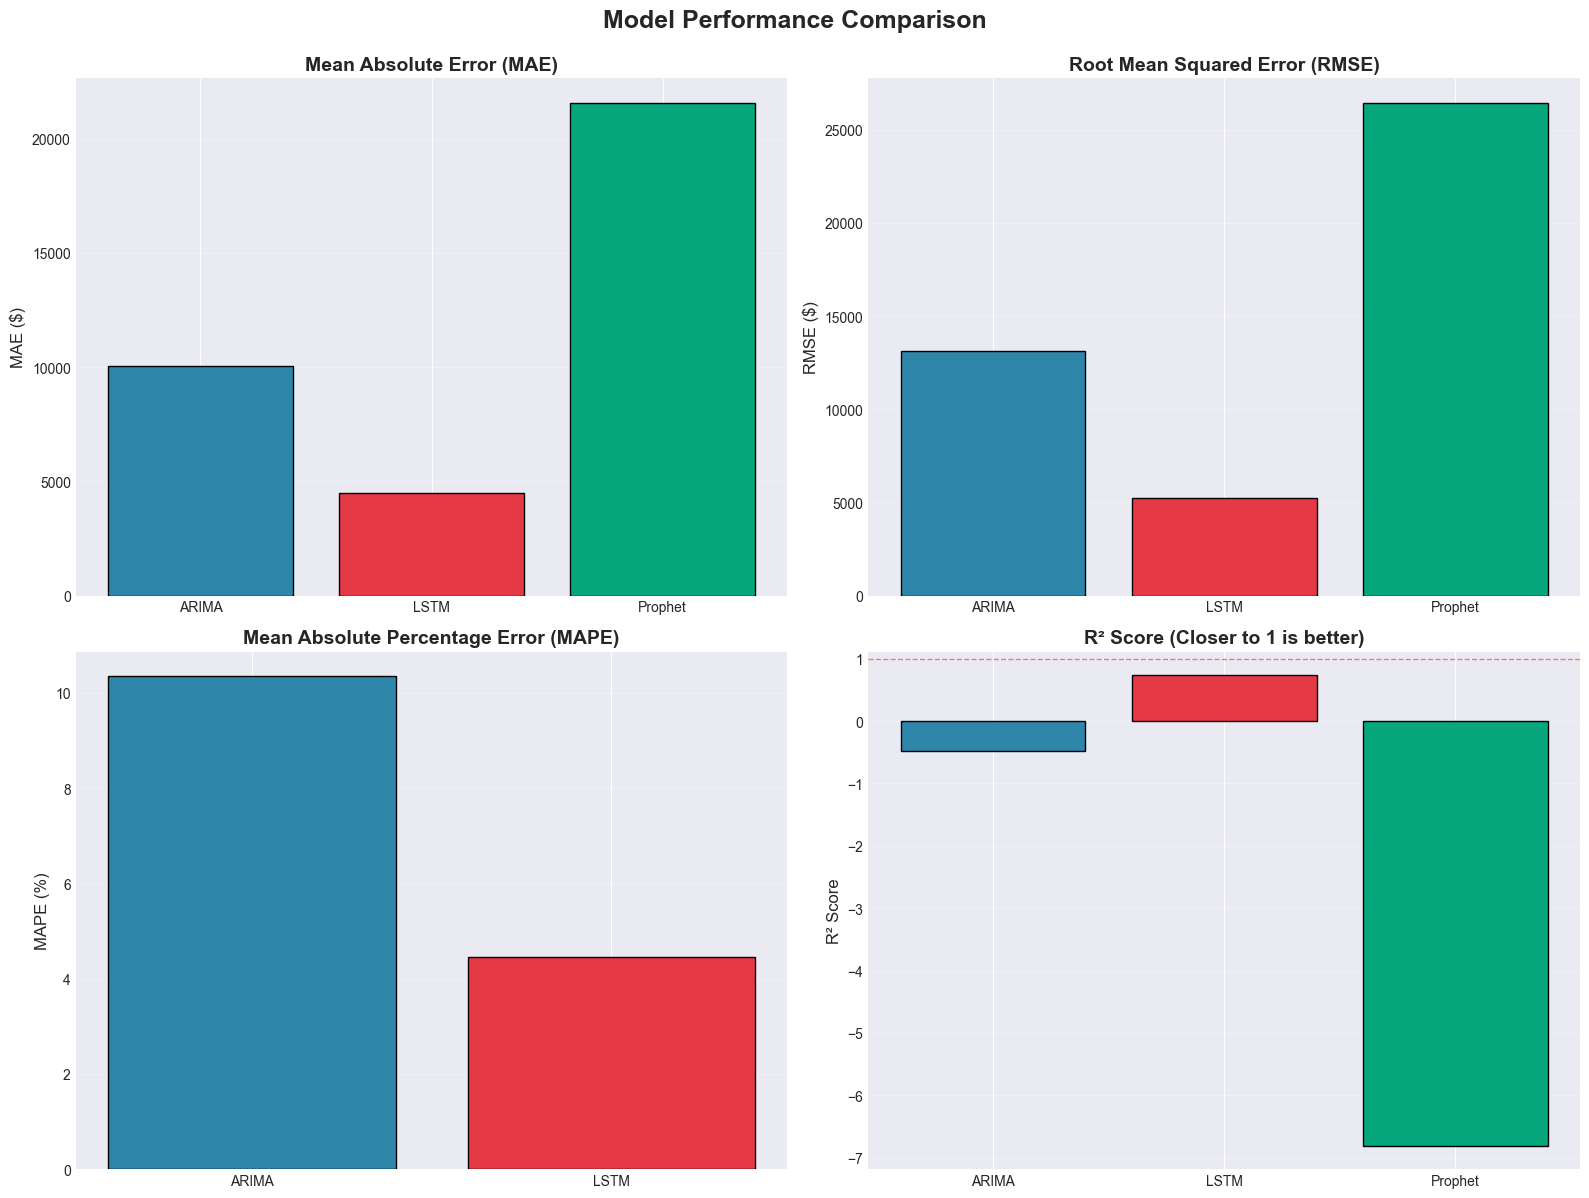

In [27]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# MAE comparison
axes[0, 0].bar(comparison['Model'], comparison['MAE'], color=['#2E86AB', '#E63946', '#06A77D'], edgecolor='black')
axes[0, 0].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('MAE ($)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# RMSE comparison
axes[0, 1].bar(comparison['Model'], comparison['RMSE'], color=['#2E86AB', '#E63946', '#06A77D'], edgecolor='black')
axes[0, 1].set_title('Root Mean Squared Error (RMSE)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('RMSE ($)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# MAPE comparison
axes[1, 0].bar(comparison['Model'], comparison['MAPE (%)'], color=['#2E86AB', '#E63946', '#06A77D'], edgecolor='black')
axes[1, 0].set_title('Mean Absolute Percentage Error (MAPE)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('MAPE (%)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# R² Score comparison
axes[1, 1].bar(comparison['Model'], comparison['R² Score'], color=['#2E86AB', '#E63946', '#06A77D'], edgecolor='black')
axes[1, 1].set_title('R² Score (Closer to 1 is better)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('R² Score', fontsize=12)
axes[1, 1].axhline(y=1, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Model Performance Comparison', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 9. Combined Forecast Visualization

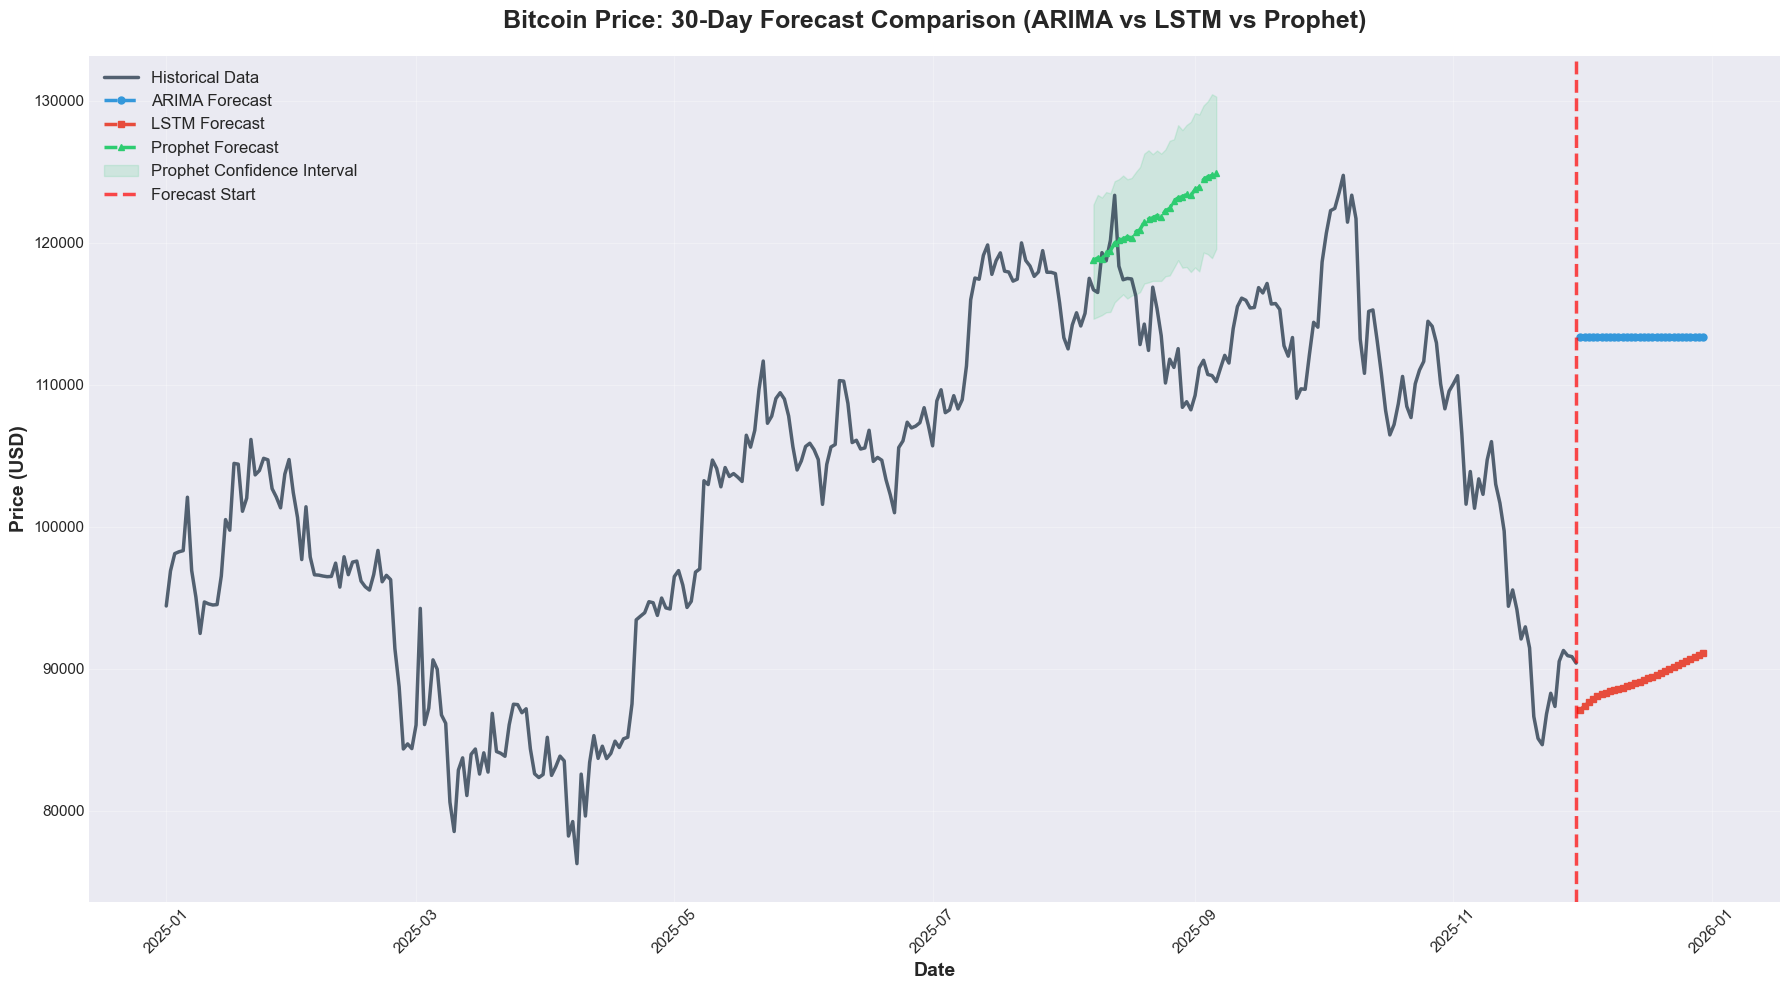

In [28]:
# Plot all three models' forecasts together
plt.figure(figsize=(18, 10))

# Historical data
plt.plot(df_ts.index, df_ts['Close'], label='Historical Data', linewidth=2.5, color='#2C3E50', alpha=0.8)

# Future dates
last_date = df_ts.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30, freq='D')

# ARIMA forecast
plt.plot(future_dates, arima_future_30, label='ARIMA Forecast', 
         linewidth=2.5, color='#3498DB', marker='o', markersize=5, linestyle='--')

# LSTM forecast
plt.plot(future_dates, lstm_future_predictions, label='LSTM Forecast', 
         linewidth=2.5, color='#E74C3C', marker='s', markersize=5, linestyle='--')

# Prophet forecast
plt.plot(prophet_future_30['ds'], prophet_future_30['yhat'], label='Prophet Forecast', 
         linewidth=2.5, color='#2ECC71', marker='^', markersize=5, linestyle='--')

# Confidence interval for Prophet
plt.fill_between(prophet_future_30['ds'], 
                 prophet_future_30['yhat_lower'], 
                 prophet_future_30['yhat_upper'], 
                 alpha=0.15, color='#2ECC71', label='Prophet Confidence Interval')

plt.axvline(x=df_ts.index[-1], color='red', linestyle='--', linewidth=2.5, label='Forecast Start', alpha=0.7)

plt.title('Bitcoin Price: 30-Day Forecast Comparison (ARIMA vs LSTM vs Prophet)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

## 10. Export Forecasts

In [29]:
# Create comprehensive forecast dataframe
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'ARIMA_Forecast': arima_future_30.values,
    'LSTM_Forecast': lstm_future_predictions.flatten(),
    'Prophet_Forecast': prophet_future_30['yhat'].values,
    'Prophet_Lower': prophet_future_30['yhat_lower'].values,
    'Prophet_Upper': prophet_future_30['yhat_upper'].values
})

# Add ensemble average
forecast_df['Ensemble_Average'] = forecast_df[['ARIMA_Forecast', 'LSTM_Forecast', 'Prophet_Forecast']].mean(axis=1)

# Save to CSV
forecast_df.to_csv('BTC_30day_forecasts.csv', index=False)

print("✓ Forecasts saved to: BTC_30day_forecasts.csv")
print("\n30-Day Forecast Summary:")
print("="*80)
print(forecast_df.to_string(index=False))
print("="*80)

✓ Forecasts saved to: BTC_30day_forecasts.csv

30-Day Forecast Summary:
      Date  ARIMA_Forecast  LSTM_Forecast  Prophet_Forecast  Prophet_Lower  Prophet_Upper  Ensemble_Average
2025-12-01   113344.429691   87119.585938     118778.771626  114647.804270  122689.425867     106414.262418
2025-12-02   113344.429691   87379.742188     118937.542555  114775.228584  123370.095910     106553.904811
2025-12-03   113344.429691   87642.601562     118862.858537  114909.108088  123190.232425     106616.629930
2025-12-04   113344.429691   87872.554688     119283.575281  115105.274078  123573.233495     106833.519887
2025-12-05   113344.429691   88059.039062     119438.245742  115131.268540  123482.819466     106947.238165
2025-12-06   113344.429691   88205.390625     119989.026304  115808.203862  124337.268142     107179.615540
2025-12-07   113344.429691   88321.156250     120183.707447  116100.475919  124478.424783     107283.097796
2025-12-08   113344.429691   88417.140625     120269.421397  116

## 11. Final Summary Report

In [30]:
print("\n" + "="*80)
print("BITCOIN PRICE FORECASTING - FINAL SUMMARY REPORT")
print("="*80)

print(f"\nDATA OVERVIEW:")
print("-" * 80)
print(f"Historical Period: {df_ts.index.min().strftime('%B %d, %Y')} to {df_ts.index.max().strftime('%B %d, %Y')}")
print(f"Total Days: {len(df_ts)}")
print(f"Current Price: ${df_ts['Close'].iloc[-1]:,.2f}")

print(f"\nMODEL PERFORMANCE ON TEST SET:")
print("-" * 80)
print(comparison.to_string(index=False))

print(f"\n30-DAY PRICE PREDICTIONS:")
print("-" * 80)
print(f"ARIMA Prediction: ${arima_future_30.iloc[-1]:,.2f} ({((arima_future_30.iloc[-1] / df_ts['Close'].iloc[-1]) - 1) * 100:+.2f}%)")
print(f"LSTM Prediction: ${lstm_future_predictions[-1][0]:,.2f} ({((lstm_future_predictions[-1][0] / df_ts['Close'].iloc[-1]) - 1) * 100:+.2f}%)")
print(f"Prophet Prediction: ${prophet_future_30['yhat'].iloc[-1]:,.2f} ({((prophet_future_30['yhat'].iloc[-1] / df_ts['Close'].iloc[-1]) - 1) * 100:+.2f}%)")
print(f"Ensemble Average: ${forecast_df['Ensemble_Average'].iloc[-1]:,.2f} ({((forecast_df['Ensemble_Average'].iloc[-1] / df_ts['Close'].iloc[-1]) - 1) * 100:+.2f}%)")

print(f"\nKEY INSIGHTS:")
print("-" * 80)
print(f"✓ Best Performing Model: {best_model} (Lowest RMSE: ${comparison.loc[best_model_idx, 'RMSE']:,.2f})")
print(f"✓ All models trained and validated successfully")
print(f"✓ 30-day forecasts generated with confidence intervals")
print(f"✓ Ensemble forecast provides robust prediction")

print(f"\nRECOMMENDATIONS:")
print("-" * 80)
print("• Use ensemble average for more robust predictions")
print("• Monitor Prophet confidence intervals for risk assessment")
print("• Consider retraining models weekly with new data")
print("• Combine predictions with fundamental analysis for decisions")

print("\n" + "="*80)
print("✓ FORECASTING ANALYSIS COMPLETE!")
print("="*80)


BITCOIN PRICE FORECASTING - FINAL SUMMARY REPORT

DATA OVERVIEW:
--------------------------------------------------------------------------------
Historical Period: January 01, 2025 to November 30, 2025
Total Days: 334
Current Price: $90,394.31

MODEL PERFORMANCE ON TEST SET:
--------------------------------------------------------------------------------
  Model          MAE         RMSE  MAPE (%)  R² Score
  ARIMA 10037.270093 13126.199258 10.342826 -0.478354
   LSTM  4485.460653  5256.765704  4.456836  0.732799
Prophet 21555.208505 26434.594185       NaN -6.806267

30-DAY PRICE PREDICTIONS:
--------------------------------------------------------------------------------
ARIMA Prediction: $113,344.43 (+25.39%)
LSTM Prediction: $91,122.09 (+0.81%)
Prophet Prediction: $124,900.14 (+38.17%)
Ensemble Average: $109,788.89 (+21.46%)

KEY INSIGHTS:
--------------------------------------------------------------------------------
✓ Best Performing Model: LSTM (Lowest RMSE: $5,256.77)
✓ All m